# Multisensory integration architecture for sign-language recognition
## Project for Neuro-Inspired Systems Engineering course at TUM

Authors of the project: Tatyana Klimenko and Cristina Gil

This script was written by Cristina Gil

# Part 1: modeling sign-language gestures

The following code aims to model from a basic perspective sign-language gestures of american sign language.
<img src="american_sign_language.png">


In [2]:
import numpy as np
import pandas as pd
from collections import *
import torch
import torch.nn as nn
from Models.TwoLayerNet import twoLayerNet # My net
import matplotlib.pyplot as plt
# from Solver import Solver # My code

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 14.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 1

%aimport Models.Solver


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Letters
letters = {}

# Fingers: Index, Middle, Ring, Little
fingers = ['index','middle','ring','little']

# Joints
'''
Angles for fingers: 
    - MCP_fe: metacarpophalangeal flexion/extension 
    - MCP_aa: metacarpophalangeal abduction/adduction
    - PIP: Proximal-interphalangeal 

Angles for thumb:
    - TMC_fe: trapeziometacarpal flexion/extension
    - TMC_aa: trapeziometacarpal abduction/adduction
    - MCP_fe: metacarpophalangeal flexion/extension
'''
angles = {'MCP_fe','MCP_aa','PIP'}
angles_thumb = {'TMC_fe','TMC_aa','MCP_fe'}


# Initialize angles to 0 (Rest position of the hand)
default_params = defaultdict(dict)

for finger in fingers:
    for angle in angles:
        default_params[finger][angle] = 0
# Thumb
for angle in angles_thumb:
    default_params['thumb'][angle]=0

# Create a dataframe from default_parameters
df = pd.DataFrame.from_dict(default_params)
print(df)

# Transform the dataframe to a row vector
array = df.as_matrix().ravel()
array = array[~np.isnan(array)]

# Number of parameters
n_params = len(array)

        index  middle  ring  little  thumb
MCP_aa    0.0     0.0   0.0     0.0    NaN
MCP_fe    0.0     0.0   0.0     0.0    0.0
PIP       0.0     0.0   0.0     0.0    NaN
TMC_aa    NaN     NaN   NaN     NaN    0.0
TMC_fe    NaN     NaN   NaN     NaN    0.0


D:\anaconda\envs\forceNet\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [4]:
# Parametrize the letters

# Letter A
A = df.copy()
A.loc['MCP_fe':'PIP','index':'ring']=90
A.loc['TMC_aa','thumb']=-45
letters['A']=A

# Letter B
B = df.copy()
B.loc['TMC_fe','thumb']=180
letters['B']=B

# Letter D
D = df.copy()
D.loc['MCP_fe','little':'thumb']=45
D.loc['PIP','little':'ring']=60
D.loc['TMC_fe','thumb'] = 90
letters['D']=D

# Letter E
E = df.copy()
E.loc['MCP_fe','index':'thumb']=90
E.loc['PIP','index':'ring']=90
E.loc['TMC_aa','thumb']=-90
letters['E']=E

# Letter F
F = df.copy()
F.loc['MCP_fe','index']=30
F.loc['PIP','index']=90
F.loc['TMC_fe','thumb']=45
F.loc['MCP_fe','thumb']=90
letters['F']=F


In [4]:
# Print letters structure for checking
for key, value in letters.items():
    print(key, value)


A         index  little  middle  ring  thumb
MCP_aa    0.0     0.0     0.0   0.0    NaN
MCP_fe   90.0    90.0    90.0  90.0    0.0
PIP      90.0    90.0    90.0  90.0    NaN
TMC_aa    NaN     NaN     NaN   NaN  -45.0
TMC_fe    NaN     NaN     NaN   NaN    0.0
B         index  little  middle  ring  thumb
MCP_aa    0.0     0.0     0.0   0.0    NaN
MCP_fe    0.0     0.0     0.0   0.0    0.0
PIP       0.0     0.0     0.0   0.0    NaN
TMC_aa    NaN     NaN     NaN   NaN    0.0
TMC_fe    NaN     NaN     NaN   NaN  180.0
D         index  little  middle  ring  thumb
MCP_aa    0.0     0.0     0.0   0.0    NaN
MCP_fe    0.0    45.0    45.0  45.0   45.0
PIP       0.0    60.0    60.0  60.0    NaN
TMC_aa    NaN     NaN     NaN   NaN    0.0
TMC_fe    NaN     NaN     NaN   NaN   90.0
E         index  little  middle  ring  thumb
MCP_aa    0.0     0.0     0.0   0.0    NaN
MCP_fe   90.0    90.0    90.0  90.0   90.0
PIP      90.0    90.0    90.0  90.0    NaN
TMC_aa    NaN     NaN     NaN   NaN  -90.0
TMC

In [5]:
# Function for creatig samples
def create_samples(letter,n_samples,variance):
    # Convert to array and eliminate nan values
    array = letter.as_matrix().ravel()
    array = array[~np.isnan(array)]
    
    # Create samples and add gausian noise
    data = np.tile(array, (n_samples,1))
    noise = np.random.normal(0, variance, data.shape)
    params = data+noise
    
    return params

In [6]:
# Initialize variables
n_samples = 1000
variance = np.arange(5,75,10) # For noise: v degrees in all the angles  
n_letters = len(letters)

params_list = []
labels_list = []

for v in variance:
    
    # Create the parameters structure
    params = np.zeros((n_letters*n_samples,n_params))
    # labels = np.zeros(n_letters*n_samples)
    labels = np.zeros((n_letters*n_samples,n_letters))

    l=0    
    for key, letter in letters.items():

        # Params
        new_params = create_samples(letter,n_samples,v)
        params[(l*n_samples):(l*n_samples+n_samples),:] = new_params

        # Labels
        labels[(l*n_samples):(l*n_samples+n_samples),l]=1
        l+=1

    params_list.append(params)
    labels_list.append(labels)

D:\anaconda\envs\forceNet\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


# Part 2: Setting the NN

## Prepare the data

In [7]:
def prepare_data(params, labels):
    """
    Split the data in training set, validation set and test set
    """
    # Create random list of intergers to mask the input data
    a = np.arange(4999)
    np.random.shuffle(a)


    # Test set
    mask_test = np.zeros(n_letters*n_samples, dtype=bool)
    trues_test = a[:100]
    mask_test[trues_test] = True

    test_data = params[mask_test,:]
    test_labels = labels[mask_test,:]

    # Validation set
    mask_val = np.zeros(n_letters*n_samples, dtype=bool)
    trues_val = a[100:200]
    mask_val[trues_val]=True

    val_data = params[mask_val,:]
    val_labels = labels[mask_val,:]

    # Train set
    mask_train = (~mask_test)*(~mask_val)
    train_data = params[mask_train,:]
    train_labels = labels[mask_train,:]


    print("Train size: %i" % len(train_data))
    print("Val size: %i" % len(val_data))
    print("Test size: %i" % len(test_data))
    
    # Pack everything into data
    data = {}
    data_test = {}
    data_test ["test_data"] = test_data
    data_test ["test_labels"] = test_labels
    data["val_data"] = val_data
    data["val_labels"] = val_labels
    data["train_data"] = train_data
    data["train_labels"] = train_labels


    return data, data_test


## Define and train the network

In [10]:
losses = []
accuracies = []
test_accuracies = np.zeros(len(variance))
# Try different data with different variances
for i, v in enumerate(variance):
    print("Variance: %d" %(v))
    #Split the data into training set, validation set and test set
    data, data_test = prepare_data(params_list[i],labels_list[i])

    # Define net hyperparamethers
    D_in = data["train_data"].shape[1] # Input dimension: 15 joint parameters
    H = 100                    # Dimension of the hidden layer
    D_out = n_letters          # Output dimension: Number of letters to clasify

    # Create an instance of the network
    net = twoLayerNet(D_in, H, D_out)
    
    if v == 15:
        # Save the Network
        torch.save(net, 'twoLayer.pth')

    # Solver instance to train the network
    solver = Models.Solver.Solver(net, data, learning_rate = 1e-3, num_epochs = 2, batch_size = 64)
    solver.train()
    
    # Save losses and accuracies
    losses.append(solver.loss_history.ravel())
    accuracies.append(solver.acc_history)
    
    # Test the network
    # Calculate the predicted labels from the validation dataset
    test_data = data_test["test_data"]
    test_labels = data_test["test_labels"]

    y_pred = net(torch.from_numpy(np.float32(test_data)))
    _, predicted = torch.max(y_pred,1) # Classes

    # Ground truth
    test_labels = np.argmax(test_labels, axis = 1)

    test_acc = sum(predicted.numpy() == test_labels)/len(test_labels)
    test_accuracies[i] = test_acc
    print(test_acc)


Variance: 5
Train size: 4800
Val size: 100
Test size: 100
[1,     1] loss: 0.056 train accuracy: 45.50
[1,    11] loss: 0.001 train accuracy: 99.70
[1,    21] loss: 0.000 train accuracy: 99.80
[1,    31] loss: 0.000 train accuracy: 99.70
[1,    41] loss: 0.000 train accuracy: 99.50
[1,    51] loss: 0.000 train accuracy: 99.90
[1,    61] loss: 0.000 train accuracy: 99.90
[1,    71] loss: 0.000 train accuracy: 100.00
[2,     1] loss: 0.000 train accuracy: 99.70
[2,    11] loss: 0.000 train accuracy: 100.00
[2,    21] loss: 0.000 train accuracy: 100.00
[2,    31] loss: 0.000 train accuracy: 100.00
[2,    41] loss: 0.000 train accuracy: 100.00
[2,    51] loss: 0.000 train accuracy: 100.00
[2,    61] loss: 0.000 train accuracy: 100.00
[2,    71] loss: 0.000 train accuracy: 100.00
Finished Training



1.0
Variance: 15
Train size: 4800
Val size: 100
Test size: 100
[1,     1] loss: 0.183 train accuracy: 20.20
[1,    11] loss: 0.003 train accuracy: 91.00
[1,    21] loss: 0.003 train accuracy: 9

Text(0.5,0,'Iterations')

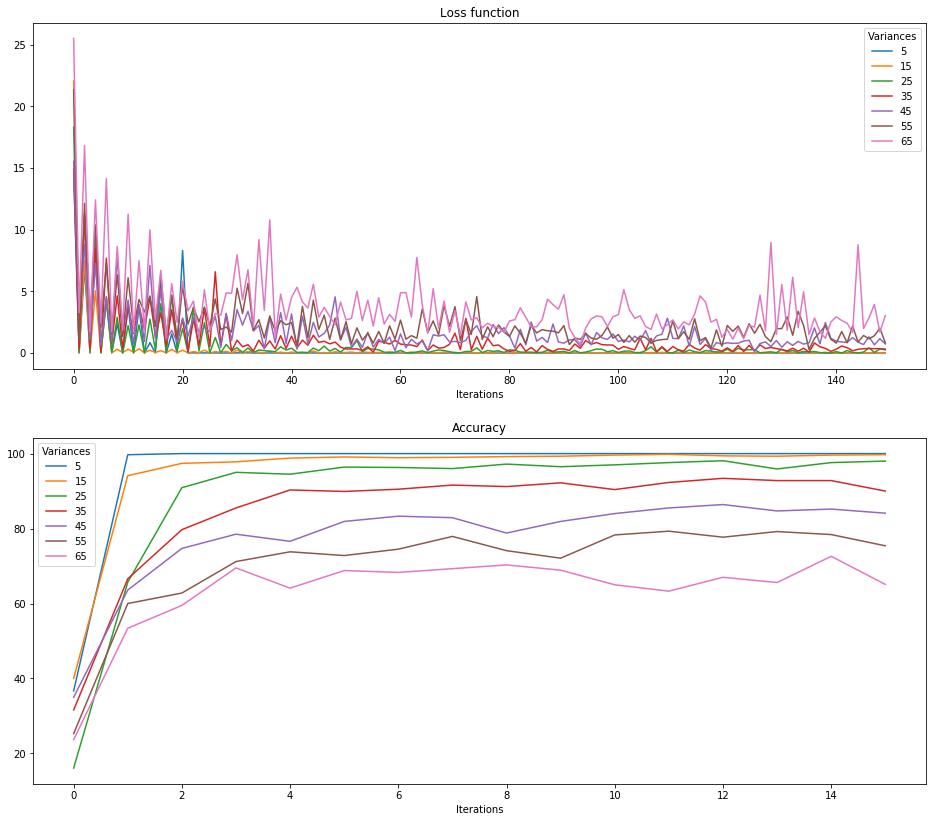

In [12]:
# Print loss history
plt.subplot(2,1,1)
plt.plot(np.stack(losses, axis = 0).T)
plt.legend(variance, title = 'Variances')
plt.title('Loss function')
plt.xlabel("Iterations")

# Print accuracy history
plt.subplot(2,1,2)
plt.plot(np.array(accuracies).T*100)
plt.legend(variance, title = 'Variances')
plt.title('Accuracy')
plt.xlabel("Iterations")

## Test the network

Text(0.5,1,'Decay in accuracy as data gets noisier')

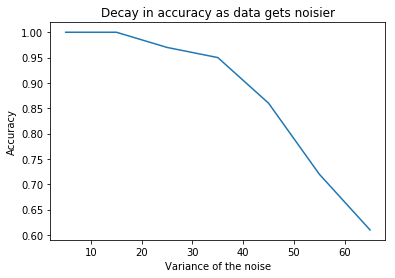

In [10]:
plt.plot(variance, test_accuracies)
plt.xlabel('Variance of the noise')
plt.ylabel('Accuracy')
plt.title('Decay in accuracy as data gets noisier')